In [93]:
import numpy as  np
from sklearn.model_selection import ParameterGrid 

In [94]:
variable_parameters = {
    "Social_network_size": range(8, 12, 1),
    "early_adaptor_prob": np.arange(0.001, 0.01, 0.002),
    "stagnator_prob": np.arange(0.1, 1, 0.2),
    "early_adaptor_lower_threshold": np.arange(2, 9, 1),
    "early_adaptor_upper_threshold": np.arange(2, 9, 1),
    "selected_country": ["Lithuania", "Germany"],
}

In [95]:
total = list(ParameterGrid(variable_parameters))

In [96]:
len(total)

9800

In [97]:
#import mesa
import pickle
import pandas as pd
import numpy as  np

In [98]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages

In [99]:
market_size_comparison = pd.read_excel(f"Input/Market penetration.xlsx")
market_size_comparison.head()

,year,scenario
0,1,0.00000
1,2,0.01215
2,3,0.02430
3,4,0.03645
4,5,0.04860


# Single run output analysis

In [36]:
# with open('/home/Output/datacollector.pickle', 'rb') as handle:
#     df = pickle.load(handle)
    
# model_output = df.get_model_vars_dataframe()

# agent_output = df.get_agent_vars_dataframe()

In [37]:
# fig, ax = plt.subplots()
# ax.plot(model_output.Month, model_output['Number of autonomous vehicles'].values)

# ax.set(xlabel='Month', ylabel='Number of autonomous vehicles',
#        title='Market penetration of autonomous vehicles')
# ax.grid()

# fig.savefig(f"/home/Result_analysis/Market penetration single model - {selected_country}.png")
# plt.show()

# Batchrunner run output analysis

In [73]:
df = pd.read_csv(f"Output/batchrunner model output.csv")
df = df.drop(['Unnamed: 0'], axis=1)

In [74]:
columns = ['early_adaptor_prob', 'stagnator_prob', 'early_adaptor_lower_threshold', 'early_adaptor_upper_threshold', 'Social_network_size', 'Number_households'] 
df['id'] = df[columns].agg(lambda x: ','.join(x.astype(str).values), axis=1).T

In [75]:
df

,Total fines collected,Total CO2,Total welfare,Total savings,Number of autonomous vehicles,Number of early adaptors,Number of stagnators,Number of healthy households,Number of accident households,Number of injured households,...,scenario_id,early_adaptor_prob,stagnator_prob,early_adaptor_lower_threshold,early_adaptor_upper_threshold,Social_network_size,Number_households,selected_country,Iteration,id
0,0.00000,131240.279977,51507,1.658011e+05,0,2,191,995,2,3,...,0,0.001,0.1,0,3,8,1000,Lithuania,1,"0.001,0.1,0.0,3.0,8.0,1000.0"
1,0.00000,131731.380019,102257,3.318204e+05,0,3,275,999,0,1,...,0,0.001,0.1,0,3,8,1000,Lithuania,1,"0.001,0.1,0.0,3.0,8.0,1000.0"
2,0.00000,131048.476676,154119,4.975684e+05,0,4,340,994,3,3,...,0,0.001,0.1,0,3,8,1000,Lithuania,1,"0.001,0.1,0.0,3.0,8.0,1000.0"
3,0.00000,131118.790939,204843,6.634899e+05,0,6,402,997,1,2,...,0,0.001,0.1,0,3,8,1000,Lithuania,1,"0.001,0.1,0.0,3.0,8.0,1000.0"
4,0.00000,131223.002722,255897,8.294137e+05,0,6,462,998,0,2,...,0,0.001,0.1,0,3,8,1000,Lithuania,1,"0.001,0.1,0.0,3.0,8.0,1000.0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14999995,302.20002,88560.858297,52134772,9.534117e+07,656,11,985,995,0,1,...,24999,0.009,0.9,9,9,12,1000,Lithuania,1,"0.009000000000000001,0.9000000000000001,9.0,9...."
14999996,302.20002,88459.858467,52225851,9.550971e+07,656,8,988,995,1,0,...,24999,0.009,0.9,9,9,12,1000,Lithuania,1,"0.009000000000000001,0.9000000000000001,9.0,9...."
14999997,302.20002,88356.940310,52317018,9.567828e+07,656,7,989,996,0,0,...,24999,0.009,0.9,9,9,12,1000,Lithuania,1,"0.009000000000000001,0.9000000000000001,9.0,9...."
14999998,302.20002,88094.160102,52407999,9.584675e+07,656,12,984,995,0,1,...,24999,0.009,0.9,9,9,12,1000,Lithuania,1,"0.009000000000000001,0.9000000000000001,9.0,9...."


# select stable change

In [76]:
df['market_size'] =  df['Number of autonomous vehicles'] / df['Number_households'] 

In [77]:
df['year'] = list(df.Month.apply(lambda x: (x / 12) if x % 12 == 0 else None))

In [78]:
df.year.replace(0, np.nan, inplace=True)

In [79]:
df.year = df.year.fillna(method='backfill')
df.year = df.year.fillna(method='ffill')

In [80]:
columns = ['early_adaptor_prob', 'stagnator_prob', 'early_adaptor_lower_threshold', 'early_adaptor_upper_threshold', 'Social_network_size', 'Number_households', 'selected_country'] 
df_selected_change = df[columns + ['year', 'market_size']]
df_selected_change = df_selected_change.groupby(columns + ['year']).mean() 
df_selected_change.reset_index(inplace=True)

In [81]:
df_selected_change = df_selected_change[df_selected_change['year'] <= market_size_comparison['year'].max()]

In [82]:
df_selected_change = pd.merge(df_selected_change, market_size_comparison, on=["year"])

In [83]:
df_selected_change['market_size_compare_scenario'] = abs(df_selected_change['market_size'] - df_selected_change['scenario']) / df_selected_change['scenario']

In [84]:
df_selected_change.replace([np.inf, -np.inf], 0, inplace=True)

In [85]:
df_selected_change = df_selected_change.groupby(columns).mean() 
df_selected_change.reset_index(inplace=True)

In [86]:
selected_scenario = 'market_size_compare_scenario'

In [87]:
#df_selected_change = df_selected_change[df_selected_change['selected_country'] == 'Lithuania']
df_selected_change = df_selected_change[df_selected_change['selected_country'] == 'Germany']

In [88]:
df_selected_change = df_selected_change.nsmallest(1, selected_scenario)

In [89]:
columns = ['early_adaptor_prob', 'stagnator_prob', 'early_adaptor_lower_threshold', 'early_adaptor_upper_threshold', 'Social_network_size', 'Number_households'] 

In [90]:
df_selected_change['id'] = df_selected_change[columns].agg(lambda x: ','.join(x.astype(str).values), axis=1).T

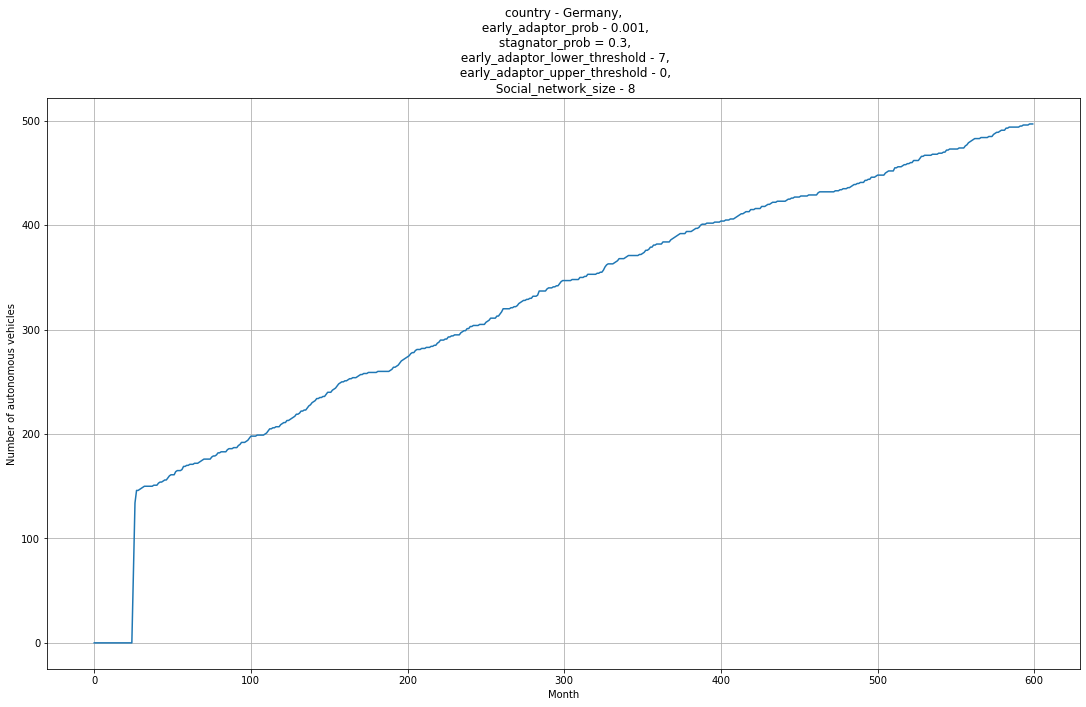

In [92]:
for selected_country in df_selected_change['selected_country'].unique():
    
    appended_data = []
    
    pp = PdfPages(f"Result_analysis/best parameters - {selected_country} - {selected_scenario}.pdf") 

    for selected_id in df_selected_change['id'].unique():

                    df_acitve = df[(df['id'] == selected_id)]
                    df_acitve = df_acitve[df_acitve['selected_country'] == selected_country]

                    selected_early_adaptor_prob = round(df_acitve['early_adaptor_prob'].unique()[0], 3)
                    selected_stagnator_prob = round(df_acitve['stagnator_prob'].unique()[0], 2)
                    selected_early_adaptor_lower_threshold = round(df_acitve['early_adaptor_lower_threshold'].unique()[0], 2)
                    selected_early_adaptor_upper_threshold = round(df_acitve['early_adaptor_upper_threshold'].unique()[0], 2)
                    selected_Social_network_size = round(df_acitve['Social_network_size'].unique()[0], 0)
                    selected_country = df_acitve['selected_country'].unique()[0]

                    if df_acitve.empty == False:
                        
                        appended_data.append(df_acitve)

                        df_acitve = df_acitve.groupby(['Month']).mean()      
                        df_acitve = df_acitve.drop(['Iteration'], axis=1)
                        df_acitve.reset_index(inplace=True)

                        fig, ax = plt.subplots()
                        fig.set_size_inches(18.5, 10.5)
                        ax.plot(df_acitve.Month, df_acitve['Number of autonomous vehicles'].values)

                        ax.set(xlabel='Month', ylabel='Number of autonomous vehicles',
                           title=f"country - {selected_country},\n early_adaptor_prob - {selected_early_adaptor_prob},\n stagnator_prob = {selected_stagnator_prob},\n early_adaptor_lower_threshold - {selected_early_adaptor_lower_threshold},\n early_adaptor_upper_threshold - {selected_early_adaptor_upper_threshold},\n Social_network_size - {selected_Social_network_size}")
                        ax.grid()

                        pp.savefig(plt.gcf())

    pp.close()    
    
    appended_data = pd.concat(appended_data)
    appended_data.to_excel(f"Result_analysis/best parameters - {selected_country} - {selected_scenario}.xlsx")

# all plots

In [201]:
df = pd.read_csv(f"Output/batchrunner model output.csv")
df = df.drop(['Unnamed: 0'], axis=1)

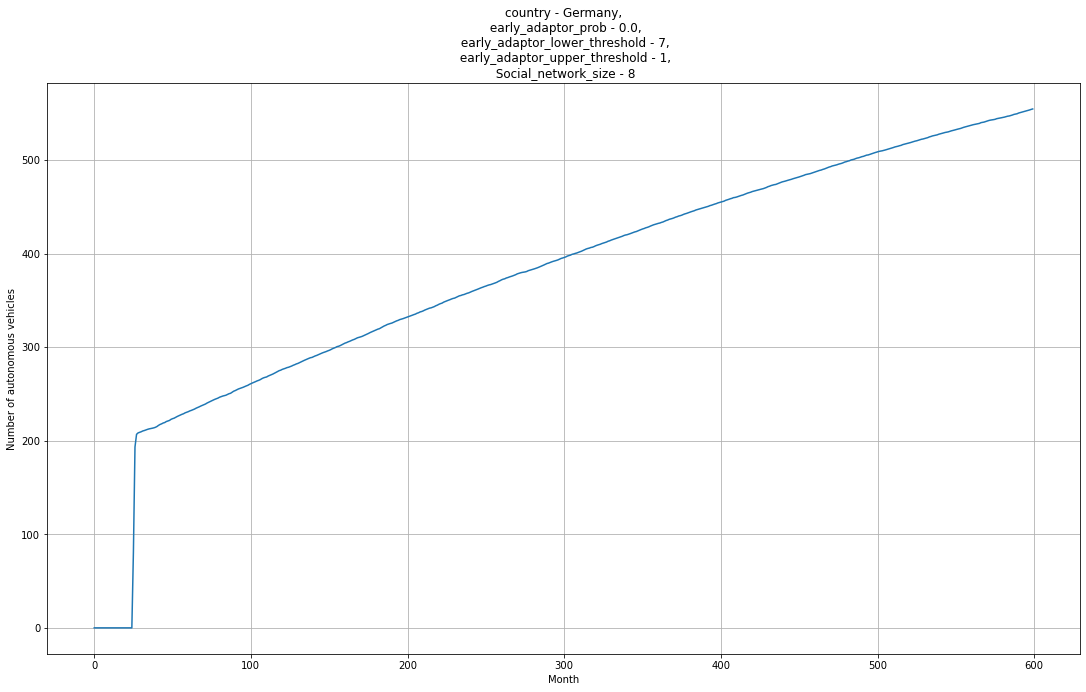

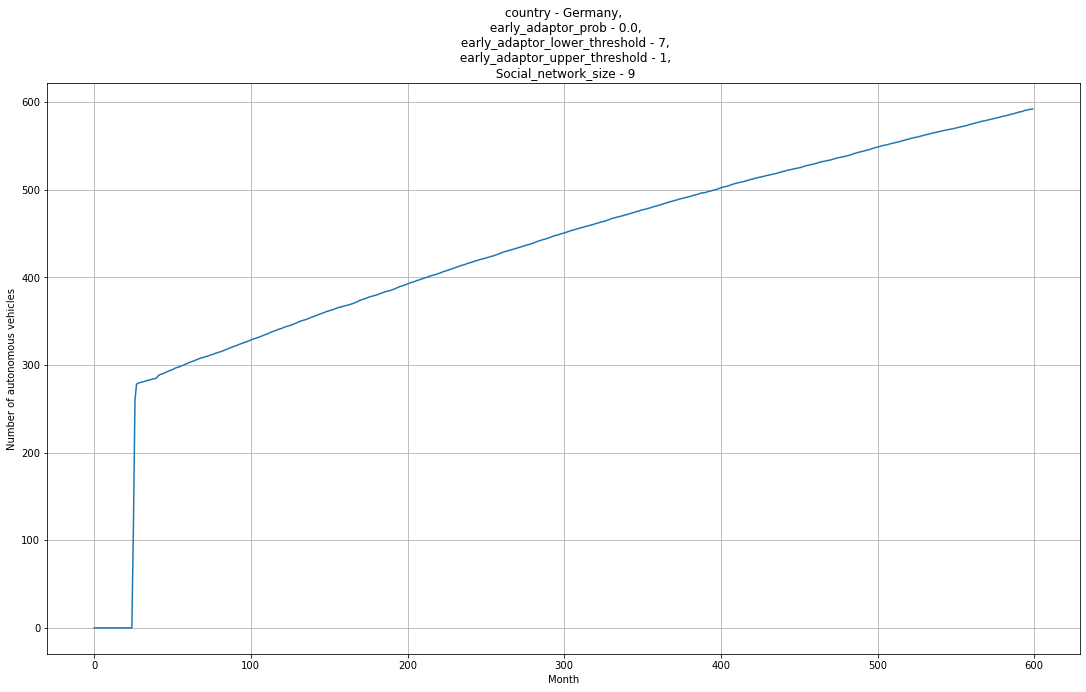

In [202]:
for selected_country in df['selected_country'].unique():
    pp = PdfPages(f"Result_analysis/Market penetration not scaled - {selected_country}.pdf") 

    for selected_early_adaptor_lower_threshold in df['early_adaptor_lower_threshold'].unique():
        for selected_early_adaptor_upper_threshold in df['early_adaptor_upper_threshold'].unique():
            for selected_Social_network_size in df['Social_network_size'].unique():
                for selected_early_adaptor_prob in df['early_adaptor_prob'].unique():

                    df_acitve = df[(df['early_adaptor_prob'] == selected_early_adaptor_prob) &
                                  (df['early_adaptor_lower_threshold'] == selected_early_adaptor_lower_threshold) &
                                  (df['early_adaptor_upper_threshold'] == selected_early_adaptor_upper_threshold) &
                                  (df['Social_network_size'] == selected_Social_network_size) &
                                  (df['selected_country'] == selected_country)]

                    selected_early_adaptor_prob = round(selected_early_adaptor_prob, 2)
                    selected_early_adaptor_lower_threshold = round(selected_early_adaptor_lower_threshold, 2)
                    selected_early_adaptor_upper_threshold = round(selected_early_adaptor_upper_threshold, 2)
                    selected_Social_network_size = round(selected_Social_network_size, 0)

                    if df_acitve.empty == False:

                        df_acitve = df_acitve.groupby(['Month']).mean()      
                        df_acitve = df_acitve.drop(['Iteration'], axis=1)
                        df_acitve.reset_index(inplace=True)

                        fig, ax = plt.subplots()
                        fig.set_size_inches(18.5, 10.5)
                        ax.plot(df_acitve.Month, df_acitve['Number of autonomous vehicles'].values)

                        ax.set(xlabel='Month', ylabel='Number of autonomous vehicles',
                           title=f"country - {selected_country},\n early_adaptor_prob - {selected_early_adaptor_prob},\n early_adaptor_lower_threshold - {selected_early_adaptor_lower_threshold},\n early_adaptor_upper_threshold - {selected_early_adaptor_upper_threshold},\n Social_network_size - {selected_Social_network_size}")
                        ax.grid()

                        pp.savefig(plt.gcf())

    pp.close()    

In [203]:
columns = ['Total fines collected', 'Total CO2', 'Total welfare',
           'Total savings', 'Number of autonomous vehicles',
           'Number of early adaptors', 'Number of stagnators', 'Number of healthy households',
           'Number of accident households', 'Number of injured households',
           'Number of dead households']

In [204]:
selected_number_households = df['Number_households'].unique()[0]
LT_population = 1267316
LT_scale = LT_population / selected_number_households

DE_population = 6562369
DE_scale = DE_population / selected_number_households

In [205]:
df.to_csv(f"Result_analysis/batchrunner model output not scaled.csv", index = False)

In [206]:
df.loc[df['selected_country'] == "Germany", columns] = df[columns] * DE_scale
df.loc[df['selected_country'] == "Lithuania", columns] = df[columns] * LT_scale

In [207]:
df.to_csv(f"Result_analysis/batchrunner model output scaled.csv", index = False)

In [208]:
df

,Total fines collected,Total CO2,Total welfare,Total savings,Number of autonomous vehicles,Number of early adaptors,Number of stagnators,Number of healthy households,Number of accident households,Number of injured households,...,Month,scenario_id,early_adaptor_prob,stagnator_prob,early_adaptor_lower_threshold,early_adaptor_upper_threshold,Social_network_size,Number_households,selected_country,Iteration
0,0.000,8.601249e+08,3.495735e+09,4.247367e+09,0.000,19687.107,3373057.666,6385185.037,6562.369,170621.594,...,0,0,0.001,0.3,7,1,8,1000,Germany,1
1,0.000,8.581073e+08,6.996489e+09,8.495993e+09,0.000,26249.476,4403349.599,6391747.406,0.000,170621.594,...,1,0,0.001,0.3,7,1,8,1000,Germany,1
2,0.000,8.633044e+08,1.048294e+10,1.274292e+10,0.000,19687.107,4948026.226,6365497.930,0.000,196871.070,...,2,0,0.001,0.3,7,1,8,1000,Germany,1
3,0.000,8.601471e+08,1.395441e+10,1.697323e+10,0.000,6562.369,5459891.008,6345810.823,0.000,216558.177,...,3,0,0.001,0.3,7,1,8,1000,Germany,1
4,0.000,8.612344e+08,1.744862e+10,2.121893e+10,0.000,0.000,5899569.731,6365497.930,0.000,196871.070,...,4,0,0.001,0.3,7,1,8,1000,Germany,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,1299349.062,6.097796e+08,2.186281e+12,2.491254e+12,3898047.186,19687.107,6536119.524,6444246.358,0.000,104997.904,...,595,59,0.001,0.3,7,1,9,1000,Germany,30
35996,1299349.062,6.040540e+08,2.190021e+12,2.495525e+12,3898047.186,26249.476,6529557.155,6463933.465,0.000,91873.166,...,596,59,0.001,0.3,7,1,9,1000,Germany,30
35997,1299349.062,6.081911e+08,2.193747e+12,2.499765e+12,3904609.555,32811.845,6522994.786,6431121.620,0.000,124685.011,...,597,59,0.001,0.3,7,1,9,1000,Germany,30
35998,1299349.062,6.109027e+08,2.197469e+12,2.504010e+12,3911171.924,52498.952,6503307.679,6450808.727,0.000,104997.904,...,598,59,0.001,0.3,7,1,9,1000,Germany,30


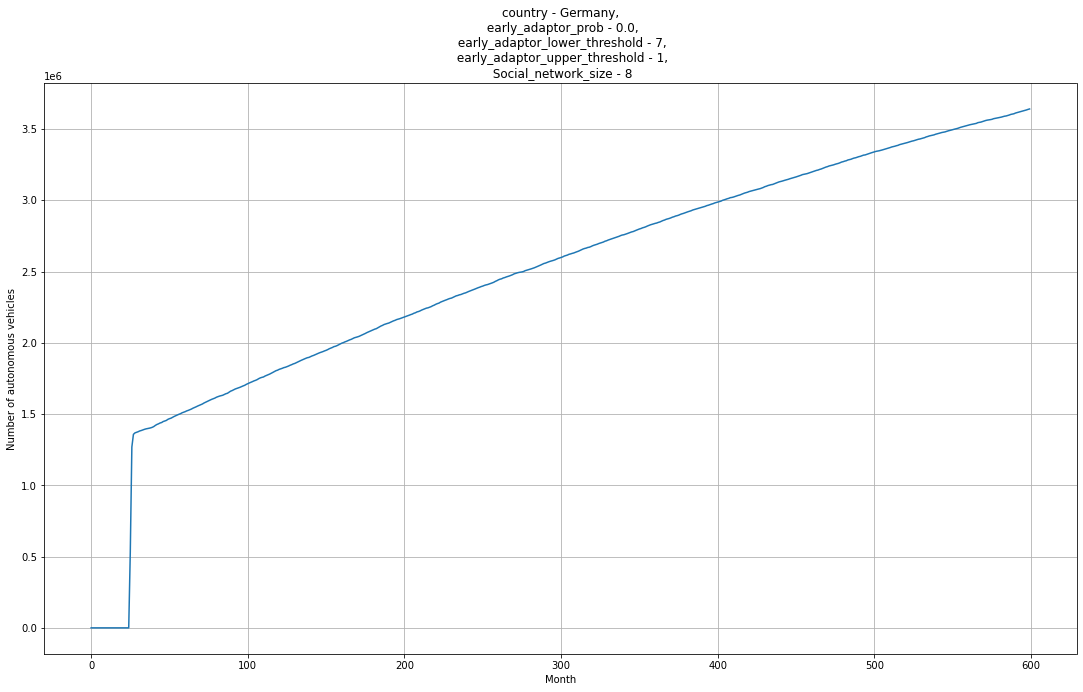

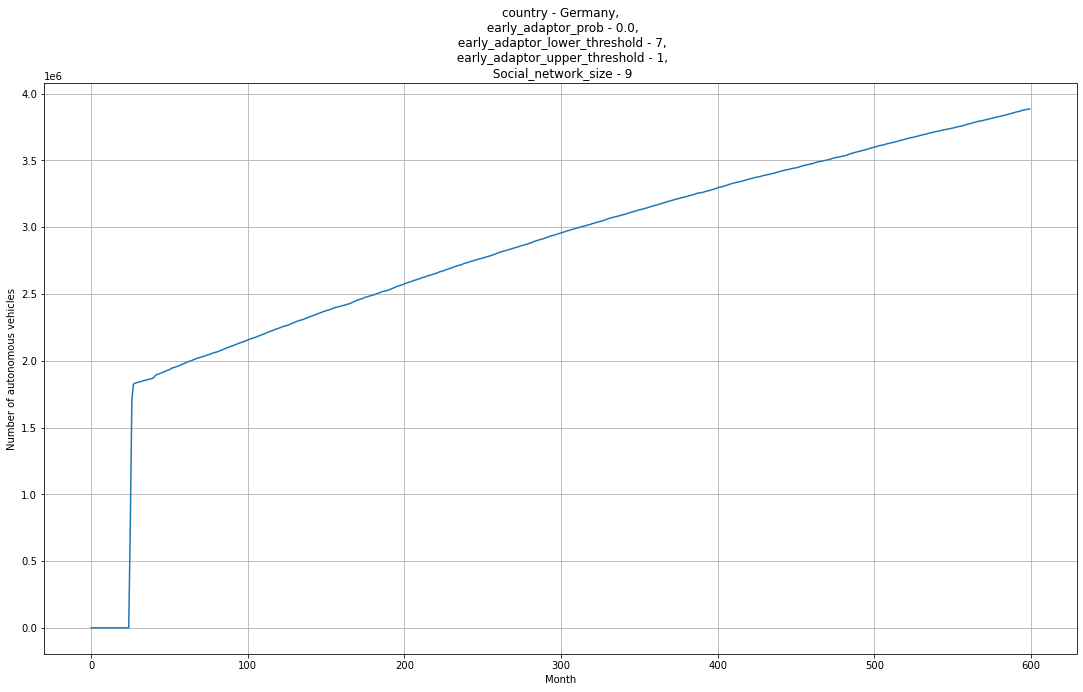

In [209]:
for selected_country in df['selected_country'].unique():
    pp = PdfPages(f"Result_analysis/Market penetration scaled - {selected_country}.pdf")

    for selected_early_adaptor_lower_threshold in df['early_adaptor_lower_threshold'].unique():
        for selected_early_adaptor_upper_threshold in df['early_adaptor_upper_threshold'].unique():
            for selected_Social_network_size in df['Social_network_size'].unique():
                for selected_early_adaptor_prob in df['early_adaptor_prob'].unique():

                    df_acitve = df[(df['early_adaptor_prob'] == selected_early_adaptor_prob) &
                                  (df['early_adaptor_lower_threshold'] == selected_early_adaptor_lower_threshold) &
                                  (df['early_adaptor_upper_threshold'] == selected_early_adaptor_upper_threshold) &
                                  (df['Social_network_size'] == selected_Social_network_size) &
                                  (df['selected_country'] == selected_country)]

                    selected_early_adaptor_prob = round(selected_early_adaptor_prob, 2)
                    selected_early_adaptor_lower_threshold = round(selected_early_adaptor_lower_threshold, 2)
                    selected_early_adaptor_upper_threshold = round(selected_early_adaptor_upper_threshold, 2)
                    selected_Social_network_size = round(selected_Social_network_size, 0)

                    if df_acitve.empty == False:

                        df_acitve = df_acitve.groupby(['Month']).mean()      
                        df_acitve = df_acitve.drop(['Iteration'], axis=1)
                        df_acitve.reset_index(inplace=True)

                        fig, ax = plt.subplots()
                        fig.set_size_inches(18.5, 10.5)
                        ax.plot(df_acitve.Month, df_acitve['Number of autonomous vehicles'].values)

                        ax.set(xlabel='Month', ylabel='Number of autonomous vehicles',
                           title=f"country - {selected_country},\n early_adaptor_prob - {selected_early_adaptor_prob},\n early_adaptor_lower_threshold - {selected_early_adaptor_lower_threshold},\n early_adaptor_upper_threshold - {selected_early_adaptor_upper_threshold},\n Social_network_size - {selected_Social_network_size}")
                        ax.grid()

                        pp.savefig(plt.gcf())

    pp.close()

# Selected parameter output analysis

In [210]:
df = pd.read_csv(f"Output/batchrunner model output.csv")
df = df.drop(['Unnamed: 0'], axis=1)

In [211]:
#selected_country = "Germany"
#selected_social_network_size = 8

selected_country = "Lithuania"
selected_social_network_size = 9

In [212]:
columns = ['Total fines collected', 'Total CO2', 'Total welfare',
           'Total savings', 'Number of autonomous vehicles',
           'Number of early adaptors', 'Number of stagnators', 'Number of healthy households',
           'Number of accident households', 'Number of injured households',
           'Number of dead households']

In [213]:
selected_number_households = df['Number_households'].unique()[0]
LT_population = 1.37 * 1000000
LT_scale = LT_population / selected_number_households

DE_population = 6562369
DE_scale = DE_population / selected_number_households

In [214]:
df.loc[df['selected_country'] == "Germany", columns] = df[columns] * DE_scale
df.loc[df['selected_country'] == "Lithuania", columns] = df[columns] * LT_scale

In [215]:
df = df[df['Social_network_size'] == selected_social_network_size]

In [216]:
df = df.drop(['Iteration'], axis=1)
df = df.groupby(['early_adaptor_prob',
                               'stagnator_prob',
                               'early_adaptor_lower_threshold',
                               'early_adaptor_upper_threshold',
                               'Social_network_size',
                               'Number_households',
                               'selected_country',
                               'Month']).mean()

df.reset_index(inplace=True)


In [217]:
df

,early_adaptor_prob,stagnator_prob,early_adaptor_lower_threshold,early_adaptor_upper_threshold,Social_network_size,Number_households,selected_country,Month,Total fines collected,Total CO2,Total welfare,Total savings,Number of autonomous vehicles,Number of early adaptors,Number of stagnators,Number of healthy households,Number of accident households,Number of injured households,Number of dead households,scenario_id
0,0.001,0.3,7,1,9,1000,Germany,0,0.000000e+00,8.590847e+08,3.418166e+09,4.173429e+09,0.000000e+00,13343.483633,3.325152e+06,6.320874e+06,437.491267,234057.827667,437.491267,44.5
1,0.001,0.3,7,1,9,1000,Germany,1,0.000000e+00,8.595500e+08,6.832255e+09,8.344343e+09,0.000000e+00,15530.939967,4.296820e+06,6.315624e+06,218.745633,239307.722867,656.236900,44.5
2,0.001,0.3,7,1,9,1000,Germany,2,0.000000e+00,8.594894e+08,1.025349e+10,1.252085e+10,0.000000e+00,16843.413767,4.970338e+06,6.327436e+06,218.745633,227276.713033,874.982533,44.5
3,0.001,0.3,7,1,9,1000,Germany,3,0.000000e+00,8.592658e+08,1.367303e+10,1.669565e+10,0.000000e+00,17280.905033,5.428610e+06,6.326780e+06,218.745633,227714.204300,1093.728167,44.5
4,0.001,0.3,7,1,9,1000,Germany,4,0.000000e+00,8.593735e+08,1.709024e+10,2.086695e+10,0.000000e+00,19468.361367,5.767229e+06,6.313218e+06,656.236900,239963.959767,1968.710700,44.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.001,0.3,7,1,9,1000,Germany,595,1.097228e+06,6.101526e+08,2.149316e+12,2.461011e+12,3.876610e+06,24280.765300,6.531526e+06,6.442059e+06,437.491267,112216.509900,1093.728167,44.5
596,0.001,0.3,7,1,9,1000,Germany,596,1.097228e+06,6.095251e+08,2.152993e+12,2.465217e+12,3.879235e+06,24062.019667,6.531745e+06,6.453652e+06,0.000000,101279.228233,874.982533,44.5
597,0.001,0.3,7,1,9,1000,Germany,597,1.097228e+06,6.094061e+08,2.156670e+12,2.469420e+12,3.882298e+06,22749.545867,6.533057e+06,6.452777e+06,656.236900,101279.228233,1093.728167,44.5
598,0.001,0.3,7,1,9,1000,Germany,598,1.097228e+06,6.094600e+08,2.160347e+12,2.473630e+12,3.883610e+06,23843.274033,6.531963e+06,6.455402e+06,0.000000,100404.245700,0.000000,44.5


In [218]:
df.to_csv(f"Result_analysis/model output scaled mean by iteration - {selected_country}.csv", index = False)

# Descriptive statistics

In [219]:
indicator = columns
total = df[columns].sum()
mean = df[columns].mean()
SD = df[columns].std()

df_statistics = pd.DataFrame(list(zip(indicator, total, mean, SD)),
               columns =['Indicator', 'Total', 'Average', 'SD'])

df_statistics['Country'] = selected_country

In [220]:
df_statistics.to_csv(f"Result_analysis/model output summary scaled - {selected_country}.csv", index = False)